In [1]:
# %%
# Imports & settings
import os
import re
import random
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import pad as torch_pad

from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
# %%
# Reproducibility & device
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device in use:', DEVICE)

Device in use: cuda


In [3]:
# %%
# Hyperparameters
VOCAB_SIZE = 20000   # top words to keep(including special tokens)
MAX_LEN = 300        # max tokens per review (pad or truncate)
EMBED_DIM = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.5
BATCH_SIZE = 64
NUM_EPOCHS = 6
LR = 1e-3

# Special token indices
PAD_IDX = 0
UNK_IDX = 1

In [4]:
# %%
# Tokenizer & helper functions
_token_pattern = re.compile(r"\b\w+\b")

def simple_tokenize(text):
    # lowercase and extract word tokens (alphanumeric + underscore)
    return _token_pattern.findall(text.lower())

# quick function to build vocab from token iterator
def build_vocab_from_iterator(iterator, max_tokens=VOCAB_SIZE, specials=("<pad>", "<unk>")):
    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)
    most_common = counter.most_common(max_tokens - len(specials))
    itos = list(specials) + [w for w, _ in most_common]
    stoi = {token: idx for idx, token in enumerate(itos)}
    return stoi, itos

# numericize tokens with stoi
def tokens_to_indices(tokens, stoi, unk_idx=UNK_IDX):
    return [stoi.get(t, unk_idx) for t in tokens]

In [5]:
# %%
# Load IMDB with Hugging Face datasets and prepare tokenized texts
print('Downloading IMDB dataset (this may take a moment)...')
dset = load_dataset('imdb')  # train/test splits

# build token iterator from training split
train_texts = dset['train']['text']
train_tokens_iter = (simple_tokenize(t) for t in train_texts)

stoi, itos = build_vocab_from_iterator(train_tokens_iter)
print(f"Vocab size (final): {len(itos)}")

Vocab size (final): 20000


In [6]:
# %%
# Dataset wrapper (numericalize on the fly or precompute)
class IMDBHF(Dataset):
    def __init__(self, split_dataset, stoi, tokenizer=simple_tokenize, max_len=MAX_LEN):
        self.texts = split_dataset['text']
        self.labels = split_dataset['label']  # 0/1
        self.stoi = stoi
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(text)
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        ids = tokens_to_indices(tokens, self.stoi)
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

# create datasets
train_ds = IMDBHF(dset['train'], stoi)
test_ds = IMDBHF(dset['test'], stoi)
print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

Train size: 25000, Test size: 25000


In [7]:
# %%
# Collate fn and DataLoaders
def collate_batch(batch):
    token_seqs, labels = zip(*batch)
    lengths = torch.tensor([t.size(0) for t in token_seqs], dtype=torch.long)
    padded = pad_sequence(token_seqs, batch_first=True, padding_value=PAD_IDX)
    # ensure width is MAX_LEN
    if padded.size(1) < MAX_LEN:
        pad_w = MAX_LEN - padded.size(1)
        padded = torch.nn.functional.pad(padded, (0, pad_w), value=PAD_IDX)
    labels = torch.tensor(labels, dtype=torch.float)
    return padded.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [23]:
# %%
# Model definition
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=128, num_layers=1, bidirectional=True, dropout=0.5, padding_idx=PAD_IDX):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.embedding_dropout = nn.Dropout1d(0.2)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x, lengths=None):
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)
        emb = emb.permute(0,2,1)  # (batch, embed_dim, seq_len)
        emb = self.embedding_dropout(emb)
        emb = emb.permute(0,2,1)

        out, (h_n, c_n) = self.lstm(emb)
        if self.lstm.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]
        h_final = self.dropout(h_final)
        return torch.sigmoid(self.fc(h_final)).squeeze(1)

model = LSTMSentiment(len(itos), EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS, BIDIRECTIONAL, DROPOUT, padding_idx=PAD_IDX).to(DEVICE)
print(model)

LSTMSentiment(
  (embedding): Embedding(20000, 128, padding_idx=0)
  (embedding_dropout): Dropout1d(p=0.2, inplace=False)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [15]:
# %%
# Loss, optimizer, metric
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def binary_accuracy(preds, y):
    rounded = (preds >= 0.5).float()
    return (rounded == y).float().mean()

In [16]:
# %%
# Training loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    steps = 0
    for inputs, lengths, labels in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(inputs, lengths)
        loss = criterion(preds, labels)
        acc = binary_accuracy(preds, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        steps += 1
    train_losses.append(epoch_loss / steps)
    train_accs.append(epoch_acc / steps)

    # validation
    model.eval()
    v_loss = 0.0
    v_acc = 0.0
    v_steps = 0
    with torch.no_grad():
        for inputs, lengths, labels in test_loader:
            preds = model(inputs, lengths)
            loss = criterion(preds, labels)
            acc = binary_accuracy(preds, labels)
            v_loss += loss.item()
            v_acc += acc.item()
            v_steps += 1
    val_losses.append(v_loss / v_steps)
    val_accs.append(v_acc / v_steps)

    print(f"Epoch {epoch}/{NUM_EPOCHS} — train_loss: {train_losses[-1]:.4f}, train_acc: {train_accs[-1]:.4f} — val_loss: {val_losses[-1]:.4f}, val_acc: {val_accs[-1]:.4f}")

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/6 — train_loss: 0.6722, train_acc: 0.5825 — val_loss: 0.6403, val_acc: 0.6508


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/6 — train_loss: 0.6312, train_acc: 0.6488 — val_loss: 0.6447, val_acc: 0.6201


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/6 — train_loss: 0.5880, train_acc: 0.6934 — val_loss: 0.5634, val_acc: 0.7227


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/6 — train_loss: 0.5475, train_acc: 0.7236 — val_loss: 0.6102, val_acc: 0.6641


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/6 — train_loss: 0.4706, train_acc: 0.7879 — val_loss: 0.8632, val_acc: 0.5824


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/6 — train_loss: 0.4109, train_acc: 0.8237 — val_loss: 0.4669, val_acc: 0.8102


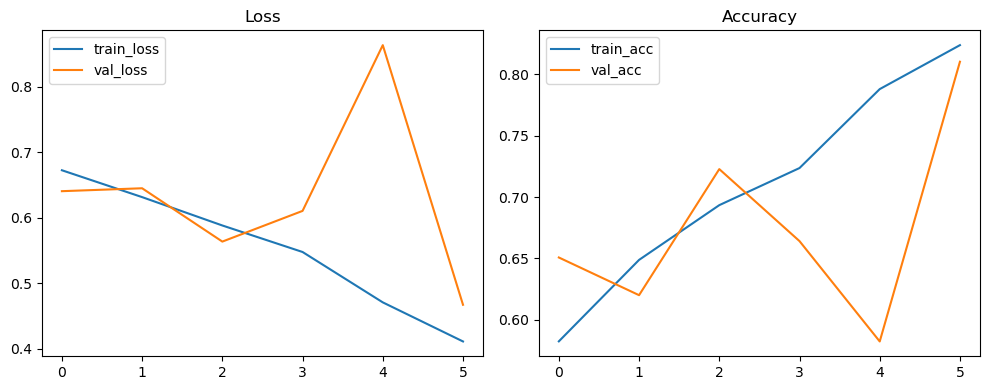

In [17]:
# %%
# Plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='train_acc')
plt.plot(val_accs, label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

In [18]:
# %%
# Save model + vocab
os.makedirs('models', exist_ok=True)
model_path = 'models/imdb_lstm_hf.pt'
torch.save({'model_state_dict': model.state_dict(), 'itos': itos}, model_path)
print('Saved model to', model_path)

Saved model to models/imdb_lstm_hf.pt


In [22]:
# %%
# Inference helper

def predict_text(text, model, stoi, tokenizer=simple_tokenize, max_len=MAX_LEN):
    model.eval()
    tokens = tokenizer(text)
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    ids = tokens_to_indices(tokens, stoi)
    tensor = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(DEVICE)
    lengths = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    with torch.no_grad():
        prob = model(tensor, lengths).item()
    return prob

# quick demo
examples = [
    "This movie was a masterpiece: direction, actors and soundtrack all excellent.",
    "Awful film. I fell asleep and the plot made no sense."
]
for ex in examples:
    p = predict_text(ex, model, stoi)
    print(f"{p:.3f}	{ 'POS' if p>=0.5 else 'NEG' }	{ex}")

0.985	POS	This movie was a masterpiece: direction, actors and soundtrack all excellent.
0.022	NEG	Awful film. I fell asleep and the plot made no sense.
